In [1]:
# !rm -rf DENTEX_000_test_image.png
# !rm -rf DENTEX_015_test_image.png

Ячейка 1

In [2]:
# 1. Установка необходимых библиотек
!pip install -q tensorflow opencv-python matplotlib scikit-learn scikit-image huggingface_hub

# Импорт необходимых библиотек
import os
import json
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from PIL import Image, ImageDraw
import cv2
from pathlib import Path
import random
import time
import shutil
from google.colab import drive
import glob
import subprocess

Ячейка 2

In [3]:
# 2. Настройка окружения и конфигурация
# Настройка памяти GPU, если доступна
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"Использование {len(gpus)} GPU")
    except RuntimeError as e:
        print(e)
else:
    print("GPU не обнаружен, используется CPU")

# Монтирование Google Drive (если потребуется сохранить результаты)
drive.mount('/content/drive')

# Создание директории для результатов
RESULTS_DIR = '/content/results'
os.makedirs(RESULTS_DIR, exist_ok=True)

# Конфигурация системы
CONFIG = {
    "img_size": 512,           # Размер входного изображения
    "batch_size": 8,           # Размер батча
    "epochs": 100,             # Количество эпох
    "early_stopping": 10,      # Ранняя остановка (количество эпох)
    "learning_rate": 1e-4,     # Скорость обучения
    "validation_split": 0.2,   # Доля данных для валидации
    "target_metrics": {        # Веса метрик для целевой функции
        "sensitivity_weight": 1.0,
        "specificity_weight": 1.0,
        "accuracy_weight": 1.0,
        "f1_score_weight": 1.0
    }
}

GPU не обнаружен, используется CPU
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Ячейка 3

In [4]:
# 3. Функция для загрузки датасета DENTEX
def download_dentex_dataset():
    """
    Скачивание и распаковка датасета DENTEX.
    """
    from huggingface_hub import snapshot_download

    # Путь для сохранения датасета
    dataset_path = '/content/DENTEX'

    # Проверяем, существует ли датасет
    if os.path.exists(dataset_path) and len(os.listdir(dataset_path)) > 0:
        print(f"Датасет уже скачан в {dataset_path}")
        return dataset_path

    print("Загрузка датасета DENTEX...")

    # Скачивание датасета с Hugging Face
    try:
        snapshot_download(
            repo_id="ibrahimhamamci/DENTEX",
            repo_type="dataset",
            local_dir=dataset_path,
            local_dir_use_symlinks=False
        )
        print(f"Датасет загружен в: {dataset_path}")
    except Exception as e:
        print(f"Ошибка при загрузке: {str(e)}")
        return None

    # Извлечение данных (если они в архиве)
    extracted_path = '/content/DENTEX_extracted'
    os.makedirs(extracted_path, exist_ok=True)

    # Проверка на наличие архивов
    archives = []
    for root, _, files in os.walk(dataset_path):
        for file in files:
            if file.endswith('.zip'):
                archives.append(os.path.join(root, file))

    # Распаковка архивов
    if archives:
        print("Распаковка архивов...")
        import zipfile
        for archive in archives:
            with zipfile.ZipFile(archive, 'r') as zip_ref:
                zip_ref.extractall(extracted_path)
        print(f"Данные распакованы в {extracted_path}")
        return extracted_path

    return dataset_path

# Загрузка датасета
dataset_path = download_dentex_dataset()
print(f"Путь к датасету: {dataset_path}")

Датасет уже скачан в /content/DENTEX
Путь к датасету: /content/DENTEX


Ячейка 4


In [5]:
def diagnose_dentex_dataset():
    """Функция для диагностики структуры датасета DENTEX"""
    print("\n=== ДИАГНОСТИКА ДАТАСЕТА DENTEX ===\n")

    # Проверяем основные директории
    base_dirs = ["/content/DENTEX", "/content/DENTEX_extracted"]
    for base_dir in base_dirs:
        if os.path.exists(base_dir):
            print(f"\n📁 Директория {base_dir} существует")

            # Показываем содержимое первого уровня
            contents = os.listdir(base_dir)
            print(f"  Содержимое ({len(contents)} элементов):")
            for item in contents[:10]:  # Показать первые 10
                item_path = os.path.join(base_dir, item)
                if os.path.isdir(item_path):
                    print(f"    📁 {item} (папка)")
                else:
                    print(f"    📄 {item} (файл)")

            if len(contents) > 10:
                print(f"    ... и еще {len(contents) - 10} элементов")

            # Проверяем наличие training_data
            training_path = os.path.join(base_dir, "training_data")
            if os.path.exists(training_path):
                print(f"\n  📁 Директория training_data найдена")

                # Проверяем поддиректории
                training_contents = os.listdir(training_path)
                print(f"    Содержимое ({len(training_contents)} элементов):")
                for item in training_contents:
                    print(f"      - {item}")

                # Проверяем наличие директории quadrant-enumeration-disease
                qed_path = os.path.join(training_path, "quadrant-enumeration-disease")
                if os.path.exists(qed_path):
                    print(f"\n    📁 Директория quadrant-enumeration-disease найдена")
                    qed_contents = os.listdir(qed_path)
                    print(f"      Содержимое ({len(qed_contents)} элементов):")
                    for item in qed_contents:
                        print(f"        - {item}")

                    # Проверяем директорию xrays
                    xrays_path = os.path.join(qed_path, "xrays")
                    if os.path.exists(xrays_path):
                        print(f"\n      📁 Директория xrays найдена!")
                        xrays_contents = os.listdir(xrays_path)
                        print(f"        Содержит {len(xrays_contents)} файлов")
                        print(f"        Примеры файлов: {', '.join(xrays_contents[:3])}")
                    else:
                        print(f"\n      ❌ Директория xrays НЕ найдена!")
                else:
                    print(f"\n    ❌ Директория quadrant-enumeration-disease НЕ найдена!")
            else:
                print(f"\n  ❌ Директория training_data НЕ найдена!")
        else:
            print(f"\n❌ Директория {base_dir} НЕ существует")

    # Ищем файлы аннотаций
    print("\n=== ПОИСК ФАЙЛОВ АННОТАЦИЙ ===\n")
    for base_dir in base_dirs:
        if not os.path.exists(base_dir):
            continue

        for root, dirs, files in os.walk(base_dir):
            json_files = [f for f in files if f.endswith('.json')]
            if json_files:
                print(f"Найдены JSON-файлы в {root}:")
                for json_file in json_files:
                    print(f"  - {json_file}")

    # Ищем PNG-файлы
    print("\n=== ПОИСК PNG-ФАЙЛОВ ===\n")
    png_locations = {}
    for base_dir in base_dirs:
        if not os.path.exists(base_dir):
            continue

        for root, dirs, files in os.walk(base_dir):
            png_files = [f for f in files if f.endswith('.png')]
            if png_files:
                png_locations[root] = len(png_files)

    # Сортируем по количеству файлов
    sorted_locations = sorted(png_locations.items(), key=lambda x: x[1], reverse=True)
    print(f"Найдено {len(sorted_locations)} директорий с PNG-файлами:")
    for location, count in sorted_locations:
        print(f"  - {location}: {count} файлов")
        if count > 0:
            # Показать примеры файлов
            examples = [f for f in os.listdir(location) if f.endswith('.png')][:3]
            print(f"    Примеры: {', '.join(examples)}")

    print("\n=== ДИАГНОСТИКА ЗАВЕРШЕНА ===\n")

# Запуск диагностики
diagnose_dentex_dataset()


=== ДИАГНОСТИКА ДАТАСЕТА DENTEX ===


📁 Директория /content/DENTEX существует
  Содержимое (5 элементов):
    📄 .gitattributes (файл)
    📁 .cache (папка)
    📄 README.md (файл)
    📁 figures (папка)
    📁 DENTEX (папка)

  ❌ Директория training_data НЕ найдена!

📁 Директория /content/DENTEX_extracted существует
  Содержимое (3 элементов):
    📁 training_data (папка)
    📁 disease (папка)
    📁 validation_data (папка)

  📁 Директория training_data найдена
    Содержимое (4 элементов):
      - quadrant-enumeration-disease
      - unlabelled
      - quadrant_enumeration
      - quadrant

    📁 Директория quadrant-enumeration-disease найдена
      Содержимое (2 элементов):
        - xrays
        - train_quadrant_enumeration_disease.json

      📁 Директория xrays найдена!
        Содержит 705 файлов
        Примеры файлов: train_294.png, train_658.png, train_309.png

=== ПОИСК ФАЙЛОВ АННОТАЦИЙ ===

Найдены JSON-файлы в /content/DENTEX/DENTEX:
  - validation_triple.json
Найдены JSON-файлы

In [6]:
# Проверка конкретного файла
def check_specific_file(file_path):
    """Проверка конкретного файла с подробной диагностикой"""
    print(f"\n=== ПРОВЕРКА ФАЙЛА {file_path} ===\n")

    # Проверка существования
    exists = os.path.exists(file_path)
    print(f"os.path.exists: {exists}")

    # Проверка через Path
    from pathlib import Path
    path_exists = Path(file_path).exists()
    print(f"Path.exists: {path_exists}")

    # Проверка родительской директории
    parent_dir = os.path.dirname(file_path)
    parent_exists = os.path.exists(parent_dir)
    print(f"Родительская директория {parent_dir} существует: {parent_exists}")

    if parent_exists:
        # Список файлов в родительской директории
        try:
            files = os.listdir(parent_dir)
            print(f"Файлы в родительской директории ({len(files)}):")

            # Ищем файл с похожим именем
            base_name = os.path.basename(file_path)
            similar_files = [f for f in files if f.lower() == base_name.lower()]

            if similar_files:
                print(f"Найдены похожие файлы: {similar_files}")
            else:
                # Показать несколько примеров файлов
                print(f"Примеры файлов: {', '.join(files[:5])}")

                # Проверка на частичное совпадение
                partial_matches = [f for f in files if base_name[:5] in f]
                if partial_matches:
                    print(f"Частичные совпадения: {partial_matches}")
        except Exception as e:
            print(f"Ошибка при получении списка файлов: {e}")

    # Прямой доступ к файлу
    if exists:
        try:
            # Пробуем открыть файл
            with open(file_path, 'rb') as f:
                first_bytes = f.read(10)
                print(f"Успешно открыт файл, первые байты: {first_bytes}")
        except Exception as e:
            print(f"Ошибка при открытии файла: {e}")

    print("\n=== ПРОВЕРКА ЗАВЕРШЕНА ===\n")

# Проверим конкретный файл
check_specific_file('/content/DENTEX_extracted/training_data/quadrant-enumeration-disease/xrays/train_435.png')


=== ПРОВЕРКА ФАЙЛА /content/DENTEX_extracted/training_data/quadrant-enumeration-disease/xrays/train_435.png ===

os.path.exists: True
Path.exists: True
Родительская директория /content/DENTEX_extracted/training_data/quadrant-enumeration-disease/xrays существует: True
Файлы в родительской директории (705):
Найдены похожие файлы: ['train_435.png']
Успешно открыт файл, первые байты: b'\x89PNG\r\n\x1a\n\x00\x00'

=== ПРОВЕРКА ЗАВЕРШЕНА ===



In [7]:
# 4. Класс DENTEXDataset - с поддержкой мультиклассовой сегментации
class DENTEXDataset:
    """
    Класс для работы с датасетом DENTEX с поддержкой мультиклассовой сегментации
    """
    def __init__(self, base_dir, img_size=CONFIG["img_size"], batch_size=CONFIG["batch_size"]):
        """
        Инициализация класса для работы с данными DENTEX.

        Аргументы:
            base_dir (str): Корневая директория с данными DENTEX
            img_size (int): Размер изображения (одно значение, т.к. предполагаем квадратное изображение)
            batch_size (int): Размер батча для обучения
        """
        self.base_dir = Path(base_dir) if base_dir else None
        self.img_size = img_size
        self.batch_size = batch_size

        # Классы патологий
        self.disease_classes = {
            0: "Background",
            1: "Caries",
            2: "Deep Caries",
            3: "Periapical",
            4: "Impacted"
        }

        # Количество классов: фон (0) + 4 типа патологий
        self.num_classes = len(self.disease_classes)

        # Цветовая карта для визуализации
        self.class_colors = {
            0: [0, 0, 0],       # Черный - фон
            1: [255, 0, 0],     # Красный - кариес
            2: [0, 255, 0],     # Зеленый - глубокий кариес
            3: [0, 0, 255],     # Синий - периапикальные поражения
            4: [255, 255, 0]    # Желтый - ретинированные зубы
        }

        # Проверяем явно директорию DENTEX_extracted
        dentex_extracted = Path("/content/DENTEX_extracted")
        if dentex_extracted.exists() and (self.base_dir is None or not self.base_dir.exists()):
            print(f"Директория {self.base_dir} не найдена, используем {dentex_extracted}")
            self.base_dir = dentex_extracted

        # Пути к данным
        self.disease_xrays_dir = self._find_disease_xrays_dir()
        self.disease_annotations_file = self._find_disease_annotations_file()

        if not self.disease_xrays_dir or not self.disease_annotations_file:
            print("ВНИМАНИЕ: Не удалось найти пути к данным. Пути устанавливаются вручную.")

            # Используем известный путь к DENTEX_extracted, если он есть
            if dentex_extracted.exists():
                # Попробуем найти xrays рекурсивно
                xray_dirs = list(dentex_extracted.glob("**/xrays"))
                if xray_dirs:
                    self.disease_xrays_dir = xray_dirs[0]
                    print(f"Найдена директория с изображениями: {self.disease_xrays_dir}")
                else:
                    self.disease_xrays_dir = dentex_extracted
                    print(f"Используем корневую директорию: {self.disease_xrays_dir}")

                # Ищем JSON файлы
                json_files = list(dentex_extracted.glob("**/*.json"))
                if json_files:
                    self.disease_annotations_file = json_files[0]
                    print(f"Найден файл аннотаций: {self.disease_annotations_file}")
            else:
                # Стандартные пути по умолчанию
                self.disease_xrays_dir = Path("/content/DENTEX_extracted/training_data/quadrant-enumeration-disease/xrays")
                self.disease_annotations_file = Path("/content/DENTEX_extracted/training_data/quadrant-enumeration-disease/train_quadrant_enumeration_disease.json")

        print(f"Путь к изображениям: {self.disease_xrays_dir}")
        print(f"Путь к аннотациям: {self.disease_annotations_file}")

        # Загрузка классов из файла аннотаций
        self._load_class_definitions()

        # Загрузка изображений и аннотаций
        self.images = []
        self.annotations = []

        if self.disease_xrays_dir and self.disease_xrays_dir.exists():
            # Если нет файла аннотаций, просто загружаем изображения
            if not self.disease_annotations_file or not self.disease_annotations_file.exists():
                print("Файл аннотаций не найден. Загружаем только изображения без аннотаций.")
                self.images = [str(f) for f in self.disease_xrays_dir.glob("**/*.png")]
                self.annotations = [[] for _ in self.images]  # Пустые аннотации
                print(f"Загружено {len(self.images)} изображений без аннотаций")
            else:
                # Если есть и директория с изображениями, и файл аннотаций - загружаем всё
                self.images, self.annotations = self._load_annotations()
                print(f"Загружено {len(self.images)} изображений с аннотациями")
        else:
            print("ПРЕДУПРЕЖДЕНИЕ: Директория с изображениями не найдена!")

    def _find_disease_xrays_dir(self):
        """Поиск директории с рентгеновскими снимками с приоритетом training_data"""
        # Проверяем, есть ли "/content/DENTEX_extracted" директория
        dentex_extracted = Path("/content/DENTEX_extracted")

        # Приоритетные пути - сначала проверяем training_data
        priority_paths = [
            dentex_extracted / "training_data" / "quadrant-enumeration-disease" / "xrays",
            dentex_extracted / "training_data" / "quadrant_enumeration_disease" / "xrays",
            self.base_dir / "training_data" / "quadrant-enumeration-disease" / "xrays" if self.base_dir else None,
            self.base_dir / "training_data" / "quadrant_enumeration_disease" / "xrays" if self.base_dir else None
        ]

        # Отфильтруем None значения
        priority_paths = [path for path in priority_paths if path is not None]

        # Проверим приоритетные пути ПЕРВЫМИ
        for path in priority_paths:
            if path.exists() and path.is_dir():
                if any(path.glob("*.png")):
                    print(f"Найдена директория с изображениями по приоритетному пути: {path}")
                    return path

        # Дополнительные возможные пути
        possible_paths = [
            dentex_extracted / "validation_data" / "quadrant-enumeration-disease" / "xrays",
            dentex_extracted / "validation_data" / "quadrant_enumeration_disease" / "xrays",
            self.base_dir / "disease" / "xrays" if self.base_dir else None,
            self.base_dir / "xrays" if self.base_dir else None,
        ]

        # Отфильтруем None значения
        possible_paths = [path for path in possible_paths if path is not None]

        # Проверка дополнительных путей
        for path in possible_paths:
            if path.exists() and path.is_dir():
                if any(path.glob("*.png")):
                    return path

        # Используем рекурсивный поиск, но ТОЛЬКО если не нашли по приоритетным путям
        if dentex_extracted.exists():
            # Ищем директории с названием xrays
            xray_dirs = list(dentex_extracted.glob("**/xrays"))
            for xdir in xray_dirs:
                if any(xdir.glob("*.png")):
                    return xdir

        # Если абсолютно ничего не нашли, только тогда ищем любые PNG-файлы
        if dentex_extracted.exists():
            png_files = list(dentex_extracted.glob("**/*.png"))
            if png_files:
                parent_dir = png_files[0].parent
                print(f"ВНИМАНИЕ: Используем резервную директорию с PNG-файлами: {parent_dir}")
                return parent_dir

        return None

    def _find_disease_annotations_file(self):
        """Поиск файла с аннотациями"""
        # Проверяем, есть ли "/content/DENTEX_extracted" директория
        dentex_extracted = Path("/content/DENTEX_extracted")

        # Варианты возможных путей
        possible_paths = [
            # Пути к DENTEX_extracted
            dentex_extracted / "training_data" / "quadrant-enumeration-disease" / "train_quadrant_enumeration_disease.json",
            dentex_extracted / "validation_data" / "quadrant-enumeration-disease" / "val_quadrant_enumeration_disease.json",

            # Исходные пути относительно base_dir
            self.base_dir / "training_data" / "quadrant-enumeration-disease" / "train_quadrant_enumeration_disease.json" if self.base_dir else None,
            self.base_dir / "training_data" / "quadrant_enumeration_disease" / "train_quadrant_enumeration_disease.json" if self.base_dir else None,
            self.base_dir / "disease" / "annotations.json" if self.base_dir else None,
            self.base_dir / "annotations.json" if self.base_dir else None
        ]

        # Отфильтруем None значения
        possible_paths = [path for path in possible_paths if path is not None]

        # Прямой путь к файлам JSON в DENTEX_extracted
        if dentex_extracted.exists():
            json_files = list(dentex_extracted.glob("**/*.json"))
            if json_files:
                # Фильтруем по ключевым словам
                for json_file in json_files:
                    if "quadrant" in str(json_file) and "disease" in str(json_file) and "train" in str(json_file):
                        possible_paths.insert(0, json_file)  # Добавляем с высоким приоритетом

                # Добавляем все найденные JSON файлы с низким приоритетом
                possible_paths.extend(json_files)

        # Проверка каждого пути
        for path in possible_paths:
            if path.exists() and path.is_file():
                return path

        return None

    def _load_class_definitions(self):
        """Загрузка определений классов из файла аннотаций"""
        if not self.disease_annotations_file or not self.disease_annotations_file.exists():
            print("Файл аннотаций не найден, используются стандартные определения классов")
            return

        try:
            with open(self.disease_annotations_file, 'r') as f:
                data = json.load(f)

            # Загружаем определения категорий, если они есть
            if 'categories_1' in data:
                self.quadrant_categories = {cat['id']: cat['name'] for cat in data['categories_1']}
                print(f"Загружено {len(self.quadrant_categories)} категорий квадрантов")

            if 'categories_2' in data:
                self.tooth_categories = {cat['id']: cat['name'] for cat in data['categories_2']}
                print(f"Загружено {len(self.tooth_categories)} категорий номеров зубов")

            if 'categories_3' in data:
                self.disease_categories = {cat['id']: cat['name'] for cat in data['categories_3']}
                print(f"Загружено {len(self.disease_categories)} категорий заболеваний")

        except Exception as e:
            print(f"Ошибка при загрузке определений классов: {e}")
            import traceback
            traceback.print_exc()

    def _load_annotations(self):
        """
        Загрузка аннотаций из JSON-файла.

        Возвращает:
            tuple: (images, annotations) - списки путей к изображениям и их аннотаций
        """
        try:
            with open(self.disease_annotations_file, 'r') as f:
                data = json.load(f)

            # Проверяем, что файл содержит необходимые данные
            if 'images' not in data or 'annotations' not in data:
                print(f"Файл аннотаций в неожиданном формате. Ключи: {list(data.keys())}")
                return [], []

            # Создаем словарь изображений по ID
            images_dict = {img['id']: img for img in data['images']}

            # Группируем аннотации по ID изображения
            annotations_by_image = {}
            for ann in data['annotations']:
                img_id = ann['image_id']
                if img_id not in annotations_by_image:
                    annotations_by_image[img_id] = []
                annotations_by_image[img_id].append(ann)

            # Формируем списки изображений и аннотаций
            images = []
            annotations = []

            for img_id, img_data in images_dict.items():
                if img_id in annotations_by_image:
                    # Пробуем разные способы формирования пути к изображению
                    file_name = img_data['file_name']
                    base_name = os.path.basename(file_name)

                    # Варианты путей
                    img_paths = [
                        os.path.join(str(self.disease_xrays_dir), file_name),
                        os.path.join(str(self.disease_xrays_dir), base_name)
                    ]

                    # Проверяем существование файла
                    found = False
                    for img_path in img_paths:
                        if os.path.exists(img_path):
                            images.append(img_path)
                            annotations.append(annotations_by_image[img_id])
                            found = True
                            break

                    # Если файл не найден, проверяем все доступные PNG файлы
                    if not found:
                        # Ищем файлы с таким же базовым именем в директории
                        png_files = list(self.disease_xrays_dir.glob(f"**/{base_name}"))
                        if png_files:
                            images.append(str(png_files[0]))
                            annotations.append(annotations_by_image[img_id])
                        elif len(images) < 5:  # Ограничиваем вывод для первых 5 отсутствующих файлов
                            print(f"Не удалось найти изображение: {file_name}")

            return images, annotations
        except Exception as e:
            print(f"Ошибка при загрузке аннотаций: {e}")
            import traceback
            traceback.print_exc()
            return [], []

    def create_multiclass_masks(self, annotations, width, height):
        """
        Создание мультиклассовых масок на основе аннотаций.

        Аргументы:
            annotations (list): Список аннотаций для изображения
            width (int): Ширина изображения
            height (int): Высота изображения

        Возвращает:
            np.array: Мультиклассовая маска размером (height, width)
        """
        # Маска фона (класс 0), заполненная нулями
        mask = np.zeros((height, width), dtype=np.uint8)

        # Идентификаторы квадрантов, зубов и диагнозов для каждой аннотации
        locations = []

        for ann in annotations:
            # Получаем тип патологии (category_id_3) и преобразуем в класс 1-4
            # По умолчанию класс 1 (Caries), если нет category_id_3
            disease_class = 1  # По умолчанию Caries

            if 'category_id_3' in ann:
                # Преобразуем id категории в класс патологии (1-4)
                # Обычно category_id_3 это 0, 1, 2, 3 для разных типов патологий
                disease_id = ann['category_id_3']
                disease_class = disease_id + 1  # Добавляем 1, т.к. 0 зарезервирован для фона

            # Получаем информацию о квадранте и номере зуба
            quadrant_id = ann.get('category_id_1', 0)
            tooth_id = ann.get('category_id_2', 0)

            # Запоминаем расположение и тип патологии
            locations.append({
                'quadrant': quadrant_id,
                'tooth': tooth_id,
                'disease': disease_class
            })

            # Если есть сегментация в виде полигона
            if 'segmentation' in ann and ann['segmentation']:
                # Обработка полигонов
                for segment in ann['segmentation']:
                    # Формируем список точек для полигона
                    points = []
                    for i in range(0, len(segment), 2):
                        points.append((int(segment[i]), int(segment[i+1])))

                    # Создаем временное изображение для рисования полигона
                    temp_mask = Image.new('L', (width, height), 0)
                    ImageDraw.Draw(temp_mask).polygon(points, outline=disease_class, fill=disease_class)

                    # Обновляем маску: если уже есть класс > 0, сохраняем максимальный класс
                    # (более приоритетная патология)
                    temp_array = np.array(temp_mask)
                    mask = np.maximum(mask, temp_array)

            # Если есть bbox (ограничивающий прямоугольник)
            elif 'bbox' in ann:
                x, y, w, h = map(int, ann['bbox'])
                # Заполняем область класса патологии
                # Если там уже есть другой класс, сохраняем больший (более приоритетный)
                current_mask = mask[y:y+h, x:x+w]
                mask[y:y+h, x:x+w] = np.maximum(current_mask, disease_class)

        return mask, locations

    def preprocess_image(self, image_path):
        """
        Предобработка изображения.

        Аргументы:
            image_path (str): Путь к изображению

        Возвращает:
            np.array: Предобработанное изображение
        """
        # Загрузка изображения
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

        # Изменение размера
        img = cv2.resize(img, (self.img_size, self.img_size))

        # Нормализация
        img = img / 255.0

        # Добавление канала (требуется для U-Net)
        img = np.expand_dims(img, axis=-1)

        return img

    def prepare_dataset(self):
        """
        Подготовка датасета для обучения и валидации.

        Возвращает:
            tuple: (train_generator, val_generator, train_count, val_count)
        """
        # Проверяем, есть ли изображения
        if len(self.images) == 0:
            print("ОШИБКА: Нет доступных изображений для обучения.")
            # Создаем пустые генераторы
            def empty_generator():
                while True:
                    # Возвращаем пустые батчи нужной формы
                    batch_x = np.zeros((self.batch_size, self.img_size, self.img_size, 1))
                    batch_y = np.zeros((self.batch_size, self.img_size, self.img_size, self.num_classes))
                    yield batch_x, batch_y

            return empty_generator(), empty_generator(), 0, 0

        # Разделение на обучающую и валидационную выборки
        train_idx, val_idx = train_test_split(
            range(len(self.images)),
            test_size=CONFIG["validation_split"],
            random_state=42
        )

        train_images = [self.images[i] for i in train_idx]
        train_annotations = [self.annotations[i] for i in train_idx]

        val_images = [self.images[i] for i in val_idx]
        val_annotations = [self.annotations[i] for i in val_idx]

        print(f"Обучающая выборка: {len(train_images)} изображений")
        print(f"Валидационная выборка: {len(val_images)} изображений")

        # Создание генераторов
        train_generator = self.data_generator(train_images, train_annotations)
        val_generator = self.data_generator(val_images, val_annotations)

        return train_generator, val_generator, len(train_images), len(val_images)

    def data_generator(self, image_paths, annotations_list):
        """
        Генератор данных для обучения/валидации с мультиклассовыми масками.

        Аргументы:
            image_paths (list): Список путей к изображениям
            annotations_list (list): Список аннотаций для каждого изображения

        Yields:
            tuple: (batch_images, batch_masks) - батчи изображений и мультиклассовых масок
        """
        num_samples = len(image_paths)

        while True:
            # Перемешиваем данные
            indices = np.arange(num_samples)
            np.random.shuffle(indices)

            for start_idx in range(0, num_samples, self.batch_size):
                batch_indices = indices[start_idx:start_idx + self.batch_size]

                batch_images = []
                batch_masks = []
                batch_locations = []

                for idx in batch_indices:
                    # Загружаем и предобрабатываем изображение
                    img_path = image_paths[idx]
                    img = self.preprocess_image(img_path)

                    # Получаем оригинальные размеры изображения для создания маски
                    orig_img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                    height, width = orig_img.shape

                    # Создаем маску на основе аннотаций
                    mask, locations = self.create_multiclass_masks(annotations_list[idx], width, height)

                    # Изменяем размер маски
                    mask = cv2.resize(mask, (self.img_size, self.img_size), interpolation=cv2.INTER_NEAREST)

                    # One-hot кодирование для мультиклассовой сегментации
                    mask_onehot = np.zeros((self.img_size, self.img_size, self.num_classes), dtype=np.float32)
                    for c in range(self.num_classes):
                        mask_onehot[:, :, c] = (mask == c).astype(np.float32)

                    batch_images.append(img)
                    batch_masks.append(mask_onehot)
                    batch_locations.append(locations)

                # Преобразуем списки в массивы numpy
                batch_images = np.array(batch_images)
                batch_masks = np.array(batch_masks)

                yield batch_images, batch_masks

    def visualize_samples(self, num_samples=3):
        """
        Визуализация случайных образцов из датасета с отображением типов заболеваний.

        Аргументы:
            num_samples (int): Количество образцов для визуализации
        """
        if len(self.images) == 0:
            print("Нет доступных изображений для визуализации")
            return

        # Выбираем случайные индексы
        indices = np.random.choice(len(self.images), min(num_samples, len(self.images)), replace=False)

        plt.figure(figsize=(15, 5 * num_samples))

        for i, idx in enumerate(indices):
            # Загружаем изображение
            img_path = self.images[idx]
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

            # Получаем размеры изображения
            height, width = img.shape

            # Создаем мультиклассовую маску
            mask, locations = self.create_multiclass_masks(self.annotations[idx], width, height)

            # Создаем цветную маску для визуализации
            color_mask = np.zeros((height, width, 3), dtype=np.uint8)
            for class_id, color in self.class_colors.items():
                color_mask[mask == class_id] = color

            # Отображаем изображение
            plt.subplot(num_samples, 3, i*3 + 1)
            plt.title(f"Изображение {i+1}")
            plt.imshow(img, cmap='gray')
            plt.axis('off')

            # Отображаем цветную маску
            plt.subplot(num_samples, 3, i*3 + 2)
            plt.title(f"Маска классов {i+1}")
            plt.imshow(color_mask)
            plt.axis('off')

            # Отображаем наложение
            plt.subplot(num_samples, 3, i*3 + 3)
            plt.title(f"Наложение {i+1}")
            plt.imshow(img, cmap='gray')
            plt.imshow(color_mask, alpha=0.5)

            # Добавляем текстовые метки
            for loc in locations:
                quadrant = loc['quadrant']
                tooth = loc['tooth']
                disease_class = loc['disease']

                # Получаем название заболевания
                disease_name = self.disease_classes.get(disease_class, "Unknown")

                # Находим соответствующую аннотацию для получения координат
                for ann in self.annotations[idx]:
                    if (ann.get('category_id_1') == quadrant and
                        ann.get('category_id_2') == tooth):

                        if 'bbox' in ann:
                            # Получаем координаты из bbox
                            x, y, w, h = map(int, ann['bbox'])

                            # Масштабируем при необходимости, если изображение было изменено
                            scale_x = img.shape[1] / width
                            scale_y = img.shape[0] / height

                            x = int(x * scale_x)
                            y = int(y * scale_y)

                            # Добавляем текст с заболеванием и расположением
                            label = f"Q: {quadrant} N: {tooth} D: {disease_name}"
                            plt.gca().text(x, y, label, color='white',
                                         backgroundcolor='black', fontsize=8)
                            break

            plt.axis('off')

        plt.tight_layout()
        plt.show()

Ячейка 5

In [8]:
# 5. Класс UNetModel - с поддержкой мультиклассовой сегментации
class UNetModel:
    """
    Класс для создания и обучения модели U-Net с поддержкой мультиклассовой сегментации
    """
    def __init__(self, img_size=CONFIG["img_size"], num_classes=5):
        """
        Инициализация модели U-Net.

        Аргументы:
            img_size (int): Размер входного изображения
            num_classes (int): Количество классов (фон + типы патологий)
        """
        self.img_size = img_size
        self.num_classes = num_classes
        self.model = self._build_unet_model()

    def _conv_block(self, inputs, filters, kernel_size=3, dropout_rate=0.1, batch_norm=True):
        """
        Блок свёрточных слоев.

        Аргументы:
            inputs: Входной тензор
            filters (int): Количество фильтров
            kernel_size (int): Размер ядра свертки
            dropout_rate (float): Коэффициент dropout
            batch_norm (bool): Применять ли пакетную нормализацию

        Возвращает:
            tf.Tensor: Выходной тензор блока
        """
        x = layers.Conv2D(filters, kernel_size, padding='same', kernel_initializer='he_normal')(inputs)
        if batch_norm:
            x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)

        x = layers.Conv2D(filters, kernel_size, padding='same', kernel_initializer='he_normal')(x)
        if batch_norm:
            x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)

        if dropout_rate > 0:
            x = layers.Dropout(dropout_rate)(x)

        return x

    def _build_unet_model(self):
        """
        Построение архитектуры U-Net для мультиклассовой сегментации.

        Возвращает:
            tf.keras.Model: Модель U-Net
        """
        # Входной слой
        inputs = layers.Input((self.img_size, self.img_size, 1))

        # Энкодер (сжимающий путь)
        conv1 = self._conv_block(inputs, 64)
        pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

        conv2 = self._conv_block(pool1, 128)
        pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

        conv3 = self._conv_block(pool2, 256)
        pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)

        conv4 = self._conv_block(pool3, 512)
        pool4 = layers.MaxPooling2D(pool_size=(2, 2))(conv4)

        # Средний блок
        conv5 = self._conv_block(pool4, 1024, dropout_rate=0.3)

        # Декодер (расширяющий путь)
        up6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(conv5)
        merge6 = layers.Concatenate(axis=3)([conv4, up6])
        conv6 = self._conv_block(merge6, 512)

        up7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv6)
        merge7 = layers.Concatenate(axis=3)([conv3, up7])
        conv7 = self._conv_block(merge7, 256)

        up8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv7)
        merge8 = layers.Concatenate(axis=3)([conv2, up8])
        conv8 = self._conv_block(merge8, 128)

        up9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv8)
        merge9 = layers.Concatenate(axis=3)([conv1, up9])
        conv9 = self._conv_block(merge9, 64, dropout_rate=0)

        # Выходной слой для мультиклассовой сегментации
        # Используем softmax для мультиклассовой сегментации
        outputs = layers.Conv2D(self.num_classes, 1, activation='softmax')(conv9)

        # Создание модели
        model = keras.Model(inputs, outputs)

        return model

    def dice_coefficient(self, y_true, y_pred, smooth=1.0):
        """
        Метрика коэффициента Дайса для мультиклассовой сегментации.

        Аргументы:
            y_true: Истинные метки (one-hot)
            y_pred: Предсказанные метки (softmax)
            smooth: Сглаживание для численной стабильности

        Возвращает:
            tf.Tensor: Среднее значение коэффициента Дайса по всем классам
        """
        # Преобразуем y_true и y_pred к float32
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)

        # Вычисляем Dice для каждого класса отдельно
        dice_scores = []

        # Цикл по всем классам кроме фона
        for i in range(1, self.num_classes):  # Пропускаем фон (класс 0)
            # Извлекаем метки для текущего класса
            y_true_class = y_true[..., i]
            y_pred_class = y_pred[..., i]

            # Вычисляем пересечение и объединение
            intersection = tf.reduce_sum(y_true_class * y_pred_class)
            union = tf.reduce_sum(y_true_class) + tf.reduce_sum(y_pred_class)

            # Dice для текущего класса
            dice = (2.0 * intersection + smooth) / (union + smooth)
            dice_scores.append(dice)

        # Среднее Dice по всем классам (кроме фона)
        mean_dice = tf.reduce_mean(dice_scores)
        return mean_dice

    def weighted_categorical_crossentropy(self, class_weights=None):
        """
        Взвешенная категориальная кросс-энтропия для мультиклассовой сегментации.

        Аргументы:
            class_weights: Словарь с весами для классов {0: w0, 1: w1, ...}

        Возвращает:
            function: Функция потерь
        """
        # Веса по умолчанию: больший вес для классов патологий, меньший для фона
        if class_weights is None:
            class_weights = {0: 0.5}  # Вес для фона
            for i in range(1, self.num_classes):
                class_weights[i] = 2.0  # Веса для классов патологий

        weights = np.ones(self.num_classes)
        for i in range(self.num_classes):
            weights[i] = class_weights.get(i, 1.0)

        weights = tf.constant(weights, dtype=tf.float32)

        def loss(y_true, y_pred):
            # Преобразуем к float32
            y_true = tf.cast(y_true, tf.float32)
            y_pred = tf.cast(y_pred, tf.float32)

            # Добавляем размерность для весов
            weights_tensor = tf.reshape(weights, [1, 1, 1, self.num_classes])

            # Клиппирование для предотвращения численной нестабильности
            y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)

            # Вычисляем взвешенную кросс-энтропию
            loss = -tf.reduce_sum(
                weights_tensor * y_true * tf.math.log(y_pred),
                axis=-1
            )

            return tf.reduce_mean(loss)

        return loss

    def mean_iou(self, y_true, y_pred):
        """
        Средний IoU (Intersection over Union) для мультиклассовой сегментации.

        Аргументы:
            y_true: Истинные метки (one-hot)
            y_pred: Предсказанные метки (softmax)

        Возвращает:
            tf.Tensor: Среднее значение IoU по всем классам
        """
        # Преобразуем from softmax/one-hot к индексам классов
        y_true_argmax = tf.argmax(y_true, axis=-1)
        y_pred_argmax = tf.argmax(y_pred, axis=-1)

        iou_scores = []

        # Цикл по всем классам кроме фона
        for i in range(1, self.num_classes):  # Пропускаем фон (класс 0)
            # Создаем маски для текущего класса
            y_true_class = tf.cast(tf.equal(y_true_argmax, i), tf.float32)
            y_pred_class = tf.cast(tf.equal(y_pred_argmax, i), tf.float32)

            # Вычисляем пересечение и объединение
            intersection = tf.reduce_sum(y_true_class * y_pred_class)
            union = tf.reduce_sum(y_true_class) + tf.reduce_sum(y_pred_class) - intersection

            # IoU для текущего класса
            iou = (intersection + 1e-7) / (union + 1e-7)
            iou_scores.append(iou)

        # Среднее IoU по всем классам (кроме фона)
        mean_iou = tf.reduce_mean(iou_scores)
        return mean_iou

    def compile_model(self, custom_loss=None, learning_rate=CONFIG["learning_rate"]):
        """
        Компиляция модели с оптимизатором и функцией потерь.

        Аргументы:
            custom_loss: Пользовательская функция потерь
            learning_rate (float): Скорость обучения
        """
        optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

        # Если пользовательская функция потерь не указана, используем взвешенную кросс-энтропию
        if custom_loss is None:
            loss = self.weighted_categorical_crossentropy()
        else:
            loss = custom_loss

        self.model.compile(
            optimizer=optimizer,
            loss=loss,
            metrics=[
                self.dice_coefficient,
                self.mean_iou
            ]
        )

        # Вывод информации о модели
        self.model.summary()

    def train(self, train_generator, val_generator, train_steps, val_steps,
              epochs=CONFIG["epochs"], callbacks=None):
        """
        Обучение модели.

        Аргументы:
            train_generator: Генератор обучающих данных
            val_generator: Генератор валидационных данных
            train_steps (int): Количество шагов на эпоху для обучающих данных
            val_steps (int): Количество шагов на эпоху для валидационных данных
            epochs (int): Количество эпох
            callbacks (list): Список колбэков для обучения

        Возвращает:
            tf.keras.callbacks.History: История обучения
        """
        if callbacks is None:
            callbacks = []

        # Обучение модели
        history = self.model.fit(
            train_generator,
            steps_per_epoch=train_steps,
            epochs=epochs,
            validation_data=val_generator,
            validation_steps=val_steps,
            callbacks=callbacks
        )

        return history

    def save_model(self, filepath):
        """
        Сохранение модели.

        Аргументы:
            filepath (str): Путь для сохранения модели
        """
        # Добавляем расширение .keras, если его нет
        if not filepath.endswith('.keras') and not filepath.endswith('.h5'):
            filepath = f"{filepath}.keras"

        self.model.save(filepath)
        print(f"Модель сохранена в {filepath}")

    def load_model(self, filepath):
        """
        Загрузка модели.

        Аргументы:
            filepath (str): Путь к сохраненной модели
        """
        self.model = keras.models.load_model(
            filepath,
            custom_objects={
                'dice_coefficient': self.dice_coefficient,
                'mean_iou': self.mean_iou,
                'loss': self.weighted_categorical_crossentropy()
            }
        )
        print(f"Модель загружена из {filepath}")

    def predict(self, image):
        """
        Предсказание на изображении.

        Аргументы:
            image (np.array): Изображение для предсказания

        Возвращает:
            np.array: Маска предсказания
        """
        # Проверка размерности
        if len(image.shape) == 2:  # Если изображение в оттенках серого без канала
            image = np.expand_dims(image, axis=-1)

        if len(image.shape) == 3 and image.shape[0] != 1:  # Если нет батч-размерности
            image = np.expand_dims(image, axis=0)

        # Предсказание
        prediction = self.model.predict(image)

        # Возвращаем маску без батч-размерности
        return prediction[0]

Ячейка 6

In [11]:
# 6. Класс StomatologyDiagnosisSystem - с поддержкой мультиклассовой сегментации
class StomatologyDiagnosisSystem:
    """
    Класс для системы диагностики в стоматологической практике с поддержкой мультиклассовой сегментации
    """
    def __init__(self, dataset_path):
        """
        Инициализация системы диагностики.

        Аргументы:
            dataset_path (str): Путь к датасету DENTEX
        """
        self.dataset_path = dataset_path
        self.dataset = None
        self.model = None
        self.history = None

        # Определения классов для визуализации
        self.disease_classes = {
            0: "Background",
            1: "Caries",
            2: "Deep Caries",
            3: "Periapical",
            4: "Impacted"
        }

        # Цветовая карта для визуализации
        self.class_colors = {
            0: [0, 0, 0],       # Черный - фон
            1: [255, 0, 0],     # Красный - кариес
            2: [0, 255, 0],     # Зеленый - глубокий кариес
            3: [0, 0, 255],     # Синий - периапикальные поражения
            4: [255, 255, 0]    # Желтый - ретинированные зубы
        }

    def setup(self):
        """
        Настройка системы: инициализация датасета и модели.
        """
        print("Настройка системы диагностики...")

        # Инициализация датасета
        self.dataset = DENTEXDataset(self.dataset_path)

        # Получение количества классов из датасета
        num_classes = self.dataset.num_classes

        # Визуализация нескольких образцов для проверки
        print("Визуализация образцов данных:")
        self.dataset.visualize_samples(3)

        # Инициализация модели
        self.model = UNetModel(num_classes=num_classes)

        # Компиляция модели с взвешенной кросс-энтропией
        self.model.compile_model()

        print("Система настроена и готова к обучению")

    def train(self):
        """
        Обучение модели.
        """
        print("Подготовка данных для обучения...")

        # Подготовка генераторов данных
        train_gen, val_gen, train_count, val_count = self.dataset.prepare_dataset()

        # Проверяем, есть ли данные для обучения
        if train_count == 0:
            print("ОШИБКА: Нет доступных изображений для обучения. Обучение не будет запущено.")
            return None

        # Расчет количества шагов на эпоху
        train_steps = train_count // CONFIG["batch_size"] + (1 if train_count % CONFIG["batch_size"] > 0 else 0)
        val_steps = val_count // CONFIG["batch_size"] + (1 if val_count % CONFIG["batch_size"] > 0 else 0)

        # Настройка колбэков
        callbacks = [
            keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=CONFIG["early_stopping"],
                restore_best_weights=True
            ),
            keras.callbacks.ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.5,
                patience=5,
                min_lr=1e-6
            ),
            keras.callbacks.TensorBoard(
                log_dir=f'./logs/dentex_unet_{time.strftime("%Y%m%d-%H%M%S")}',
                histogram_freq=1
            )
        ]

        print(f"Начало обучения модели на {train_count} изображениях...")
        print(f"Обучение будет выполняться максимум {CONFIG['epochs']} эпох с ранней остановкой")
        print(f"Используется размер батча: {CONFIG['batch_size']}")

        # Обучение модели
        self.history = self.model.train(
            train_gen,
            val_gen,
            train_steps,
            val_steps,
            epochs=CONFIG["epochs"],
            callbacks=callbacks
        )

        print("Обучение завершено!")

        return self.history

    def save(self, model_path=None):
        """
        Сохранение обученной модели.

        Аргументы:
            model_path (str, optional): Путь для сохранения модели.
                                        Если не указан, генерируется автоматически.
        """
        if model_path is None:
            model_path = os.path.join(RESULTS_DIR, f"dentex_unet_model_{time.strftime('%Y%m%d-%H%M%S')}")

        # Сохранение модели
        self.model.save_model(model_path)

        # Сохранение графиков результатов обучения
        if self.history:
            self._plot_training_history(os.path.join(RESULTS_DIR, "training_history.png"))

    def load(self, model_path):
        """
        Загрузка обученной модели.

        Аргументы:
            model_path (str): Путь к сохраненной модели
        """
        # Инициализация датасета, если его еще нет
        if self.dataset is None:
            self.dataset = DENTEXDataset(self.dataset_path)

        # Получение количества классов из датасета
        num_classes = self.dataset.num_classes

        # Инициализация модели, если она еще не создана
        if self.model is None:
            self.model = UNetModel(num_classes=num_classes)

        # Загрузка модели
        self.model.load_model(model_path)

        print("Модель успешно загружена")

    def _plot_training_history(self, save_path=None):
        """
        Построение графиков обучения.

        Аргументы:
            save_path (str, optional): Путь для сохранения графика
        """
        if self.history is None:
            print("История обучения отсутствует")
            return

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

        # График потерь
        ax1.plot(self.history.history['loss'], label='Потери (обучение)')
        ax1.plot(self.history.history['val_loss'], label='Потери (валидация)')
        ax1.set_title('Динамика функции потерь')
        ax1.set_xlabel('Эпоха')
        ax1.set_ylabel('Потери')
        ax1.legend()
        ax1.grid(True)

        # График метрик
        metrics_to_plot = ['dice_coefficient', 'mean_iou']
        for metric in metrics_to_plot:
            if metric in self.history.history:
                ax2.plot(self.history.history[metric], label=f"{metric} (обучение)")
                ax2.plot(self.history.history[f"val_{metric}"], label=f"{metric} (валидация)")

        ax2.set_title('Динамика метрик')
        ax2.set_xlabel('Эпоха')
        ax2.set_ylabel('Значение')
        ax2.legend()
        ax2.grid(True)

        plt.tight_layout()

        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"График сохранен в {save_path}")

        plt.show()

    def clean_visualization(self, image_path):
        """
        Полностью новый метод визуализации без наложения текста.
        Эта функция заменяет predict_and_visualize, начиная с чистого листа.
        """
        if self.model is None:
            print("Модель не инициализирована")
            return

        # Загрузка изображения напрямую с помощью PIL вместо OpenCV
        # для гарантии отсутствия сохранённых аннотаций
        from PIL import Image
        import numpy as np

        # Загружаем изображение и конвертируем в grayscale
        pil_image = Image.open(image_path).convert('L')
        img_original = np.array(pil_image)

        # Создаем копию для предсказаний
        img_for_prediction = img_original.copy()

        # Изменяем размер для модели
        img_resized = cv2.resize(img_for_prediction, (CONFIG["img_size"], CONFIG["img_size"]))
        img_normalized = img_resized / 255.0
        img_input = np.expand_dims(img_normalized, axis=-1)
        img_input = np.expand_dims(img_input, axis=0)

        # Выполняем предсказание
        prediction_probs = self.model.model.predict(img_input)[0]
        prediction_mask = np.argmax(prediction_probs, axis=-1)

        # Изменяем размер маски обратно к оригинальному размеру
        prediction_resized = cv2.resize(prediction_mask.astype(np.uint8),
                                    (img_original.shape[1], img_original.shape[0]),
                                    interpolation=cv2.INTER_NEAREST)

        # Создаем новую цветную маску с нуля
        # Важно не использовать никакие существующие объекты, которые могут содержать текст
        height, width = img_original.shape
        color_mask = np.zeros((height, width, 3), dtype=np.uint8)

        # Заполняем цветную маску согласно классам
        for class_id, color in self.class_colors.items():
            # Находим все пиксели данного класса
            class_pixels = prediction_resized == class_id
            # Назначаем им соответствующий цвет
            color_mask[class_pixels] = color

        # Находим регионы патологий
        regions = []
        for class_id in range(1, len(self.disease_classes)):  # Пропускаем фон (класс 0)
            # Создаем бинарную маску для текущего класса
            class_mask = (prediction_resized == class_id).astype(np.uint8)

            # Находим связные компоненты
            num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(class_mask)

            # Добавляем в список регионов
            for i in range(1, num_labels):  # Пропускаем фон (метка 0)
                if stats[i, cv2.CC_STAT_AREA] < 10:  # Пропускаем очень маленькие области
                    continue

                regions.append({
                    'class_id': class_id,
                    'centroid': (int(centroids[i, 0]), int(centroids[i, 1])),
                    'area': stats[i, cv2.CC_STAT_AREA]
                })

        # Группируем регионы по местоположению в квадрантах
        grouped_regions = {}
        height, width = img_original.shape
        center_x, center_y = width // 2, height // 2

        for region in regions:
            x, y = region['centroid']

            # Определяем квадрант
            if x < center_x:
                if y < center_y:
                    quadrant = 1  # Верхний левый
                else:
                    quadrant = 3  # Нижний левый
            else:
                if y < center_y:
                    quadrant = 2  # Верхний правый
                else:
                    quadrant = 4  # Нижний правый

            # Определяем номер зуба (упрощенно)
            rel_x = abs(center_x - x) / (width / 2)
            tooth = max(1, min(8, int(rel_x * 8) + 1))

            # Создаем ключ группы
            group_key = (quadrant, tooth)

            # Добавляем регион в группу
            if group_key not in grouped_regions:
                grouped_regions[group_key] = []
            grouped_regions[group_key].append(region)

        # Создаем новую фигуру Matplotlib
        plt.figure(figsize=(16, 8))

        # Разделяем область на две части
        grid = plt.GridSpec(1, 2, width_ratios=[3, 2])

        # Левая часть - разделена на два подграфика
        left_grid = plt.GridSpecFromSubplotSpec(2, 1, subplot_spec=grid[0])

        # Верхний подграфик - оригинальное изображение
        ax_original = plt.subplot(left_grid[0])
        ax_original.set_title("Оригинальный снимок", fontsize=14)
        ax_original.imshow(img_original, cmap='gray')
        ax_original.axis('off')

        # Нижний подграфик - маска с областями патологий
        ax_mask = plt.subplot(left_grid[1])
        ax_mask.set_title("Выделенные области патологий", fontsize=14)
        ax_mask.imshow(img_original, cmap='gray')
        ax_mask.imshow(color_mask, alpha=0.5)
        ax_mask.axis('off')

        # Добавляем номера к областям патологий
        region_data = {}
        region_number = 1

        for group_key, group_regions in grouped_regions.items():
            # Пропускаем группы без патологий
            pathology_regions = [r for r in group_regions if r['class_id'] > 0]
            if not pathology_regions:
                continue

            # Вычисляем центр группы
            group_center_x = sum(r['centroid'][0] for r in pathology_regions) / len(pathology_regions)
            group_center_y = sum(r['centroid'][1] for r in pathology_regions) / len(pathology_regions)

            # Создаем круг с номером
            # Используем очень большое значение zorder (9999), чтобы гарантировать, что круг будет поверх всего
            circle = plt.Circle((group_center_x, group_center_y), 15,
                              facecolor='white', edgecolor='black', linewidth=1.5,
                              alpha=0.9, zorder=9999)
            ax_mask.add_patch(circle)

            # Добавляем номер
            ax_mask.text(group_center_x, group_center_y, str(region_number),
                        ha='center', va='center', fontsize=10, fontweight='bold',
                        color='black', zorder=10000)

            # Сохраняем данные о регионе
            region_data[region_number] = {
                'quadrant': group_key[0],
                'tooth': group_key[1],
                'pathologies': [self.disease_classes[r['class_id']] for r in pathology_regions]
            }

            region_number += 1

        # Правая часть - информация о патологиях
        ax_info = plt.subplot(grid[1])
        ax_info.set_title("Информация о патологиях", fontsize=14)
        ax_info.axis('off')

        # Добавляем информацию
        y_pos = 0.95

        # Легенда цветов
        ax_info.text(0.5, y_pos, "ТИПЫ ПАТОЛОГИЙ", ha='center', va='center',
                    fontsize=12, fontweight='bold')
        y_pos -= 0.05

        for class_id in range(1, len(self.disease_classes)):
            color = [c/255 for c in self.class_colors[class_id]]
            disease_name = self.disease_classes[class_id]

            rect = plt.Rectangle((0.1, y_pos-0.015), 0.1, 0.03,
                                facecolor=color, edgecolor='black', linewidth=1)
            ax_info.add_patch(rect)

            ax_info.text(0.25, y_pos, disease_name, ha='left', va='center', fontsize=10)
            y_pos -= 0.04

        # Разделитель
        ax_info.axhline(y=y_pos, xmin=0.05, xmax=0.95, color='gray', linestyle='-', linewidth=0.5)
        y_pos -= 0.05

        # Обнаруженные патологии
        ax_info.text(0.5, y_pos, "ОБНАРУЖЕННЫЕ ПАТОЛОГИИ", ha='center', va='center',
                    fontsize=12, fontweight='bold')
        y_pos -= 0.05

        if not region_data:
            ax_info.text(0.5, y_pos, "Значимых патологий не обнаружено",
                        ha='center', va='center', fontsize=10, style='italic')
        else:
            for num, data in sorted(region_data.items()):
                # Рисуем круг с номером
                circle = plt.Circle((0.1, y_pos), 0.015,
                                  facecolor='white', edgecolor='black', linewidth=1)
                ax_info.add_patch(circle)

                ax_info.text(0.1, y_pos, str(num), ha='center', va='center',
                            fontsize=8, fontweight='bold')

                # Информация о квадранте и зубе
                ax_info.text(0.2, y_pos, f"Q: {data['quadrant']} N: {data['tooth']}",
                            ha='left', va='center', fontsize=10, fontweight='bold')

                y_pos -= 0.04

                # Список патологий
                for pathology in data['pathologies']:
                    ax_info.text(0.25, y_pos, f"D: {pathology}",
                                ha='left', va='center', fontsize=9)
                    y_pos -= 0.03

                y_pos -= 0.01

        # Статистика
        # Считаем количество пикселей для каждого класса
        class_pixels = {}
        total_pixels = height * width

        for class_id in range(len(self.disease_classes)):
            count = np.sum(prediction_resized == class_id)
            percentage = (count / total_pixels) * 100
            class_pixels[class_id] = percentage

        # Добавляем разделитель
        ax_info.axhline(y=0.35, xmin=0.05, xmax=0.95, color='gray', linestyle='-', linewidth=0.5)

        # Заголовок статистики
        ax_info.text(0.5, 0.32, "СТАТИСТИКА", ha='center', va='center',
                    fontsize=12, fontweight='bold')

        # Количество областей
        y_pos = 0.28
        ax_info.text(0.1, y_pos, f"Всего областей с патологиями: {len(region_data)}",
                    ha='left', va='center', fontsize=10)
        y_pos -= 0.04

        # Процент площади для каждого класса патологий
        for class_id in range(1, len(self.disease_classes)):
            percentage = class_pixels.get(class_id, 0)
            if percentage > 0.01:  # Показываем только если больше 0.01%
                disease_name = self.disease_classes[class_id]
                ax_info.text(0.1, y_pos, f"{disease_name}: {percentage:.2f}%",
                            ha='left', va='center', fontsize=9)
                y_pos -= 0.03

        plt.tight_layout()
        plt.subplots_adjust(wspace=0.05)
        plt.show()

        # Вывод информации в консоль
        print("\nРезультаты анализа панорамного снимка:")

        if not region_data:
            print("Значимых патологий не обнаружено.")
        else:
            print(f"Обнаружено {len(region_data)} областей с патологиями:")

            for num, data in sorted(region_data.items()):
                print(f"\nОбласть {num} (Квадрант {data['quadrant']}, Зуб {data['tooth']}):")
                for pathology in data['pathologies']:
                    print(f"  - {pathology}")

    def _estimate_quadrant(self, x, y, image_shape):
        """
        Оценка квадранта на основе положения точки на изображении.

        Аргументы:
            x, y (int): Координаты точки
            image_shape (tuple): Размеры изображения (высота, ширина)

        Возвращает:
            int: Номер квадранта (1-4)
        """
        height, width = image_shape

        # Определяем центр изображения
        center_x = width // 2
        center_y = height // 2

        # Определяем квадрант
        if x < center_x:
            if y < center_y:
                return 1  # Верхний левый - квадрант 1
            else:
                return 3  # Нижний левый - квадрант 3
        else:
            if y < center_y:
                return 2  # Верхний правый - квадрант 2
            else:
                return 4  # Нижний правый - квадрант 4

    def _estimate_tooth_number(self, x, y, quadrant, image_shape):
        """
        Упрощенная оценка номера зуба на основе положения.

        Аргументы:
            x, y (int): Координаты точки
            quadrant (int): Номер квадранта (1-4)
            image_shape (tuple): Размеры изображения (высота, ширина)

        Возвращает:
            int: Примерный номер зуба (1-8)
        """
        height, width = image_shape
        center_x = width // 2

        # Определяем относительное положение по горизонтали
        if quadrant in [1, 3]:  # Левая сторона
            rel_x = (center_x - x) / center_x  # 0 в центре, 1 у левого края
        else:  # Правая сторона
            rel_x = (x - center_x) / center_x  # 0 в центре, 1 у правого края

        # Преобразуем в номер зуба (1-8)
        # 1 ближе к центру, 8 ближе к краю
        tooth_number = int(rel_x * 8) + 1

        # Ограничиваем диапазон
        tooth_number = max(1, min(8, tooth_number))

        return tooth_number

In [12]:
# Отладочная ячейка - запустите её перед проблемной ячейкой 13
print("Проверка определения класса DENTEXDataset")
print(f"Тип DENTEXDataset: {type(DENTEXDataset)}")
print(f"Направление класса: {dir(DENTEXDataset)}")
print(f"Объект __init__: {DENTEXDataset.__init__}")

Проверка определения класса DENTEXDataset
Тип DENTEXDataset: <class 'type'>
Направление класса: ['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_find_disease_annotations_file', '_find_disease_xrays_dir', '_load_annotations', '_load_class_definitions', 'create_multiclass_masks', 'data_generator', 'prepare_dataset', 'preprocess_image', 'visualize_samples']
Объект __init__: <function DENTEXDataset.__init__ at 0x7bd2c4993c40>


In [13]:
# # Добавьте этот код в новую ячейку и запустите её перед повторной тренировкой
# import tensorflow as tf
# import gc

# # Удаление модели из памяти
# if hasattr(system, 'model') and system.model is not None:
#     del system.model.model  # Удаляем tf.keras.Model внутри UNetModel
#     del system.model  # Удаляем UNetModel

# # Очистка сессии TensorFlow
# tf.keras.backend.clear_session()

# # Принудительный запуск сборщика мусора
# gc.collect()

# # Пересоздание объекта модели
# system.model = UNetModel()

# # Компиляция модели с исправленными метриками
# target_metrics = CONFIG["target_metrics"]
# custom_loss = system.model.combined_loss(
#     sensitivity_weight=target_metrics["sensitivity_weight"],
#     specificity_weight=target_metrics["specificity_weight"],
#     accuracy_weight=target_metrics["accuracy_weight"],
#     f1_score_weight=target_metrics["f1_score_weight"]
# )

# # Компиляция
# system.model.compile_model(custom_loss=custom_loss)

# print("Модель успешно пересоздана и скомпилирована")

Ячейка 7

Датасет уже скачан в /content/DENTEX
Настройка системы диагностики...
Найдена директория с изображениями по приоритетному пути: /content/DENTEX_extracted/training_data/quadrant-enumeration-disease/xrays
Путь к изображениям: /content/DENTEX_extracted/training_data/quadrant-enumeration-disease/xrays
Путь к аннотациям: /content/DENTEX_extracted/training_data/quadrant-enumeration-disease/train_quadrant_enumeration_disease.json
Загружено 4 категорий квадрантов
Загружено 8 категорий номеров зубов
Загружено 4 категорий заболеваний
Загружено 678 изображений с аннотациями
Визуализация образцов данных:


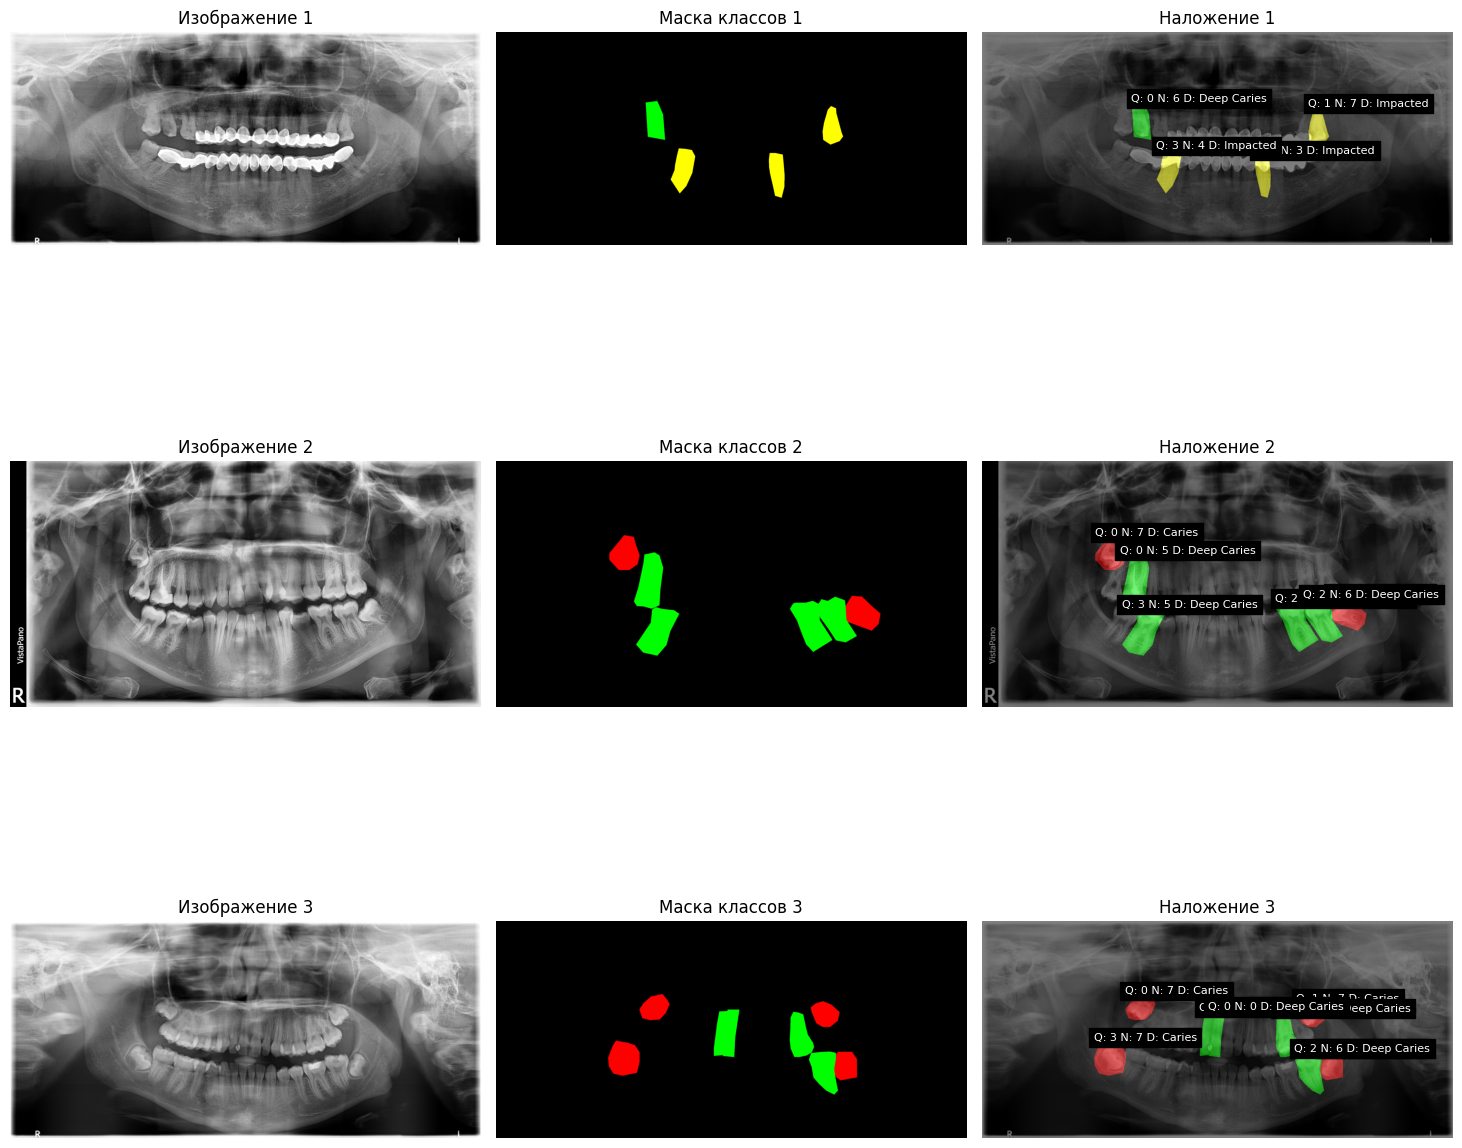

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 512, 512, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 512, 512, 64)   │            640 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 512, 512, 64)   │            256 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 512, 512, 64)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 512, 512, 64)   │         36,928 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 512, 512, 64)   │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 512, 512, 64)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 512, 512, 64)   │              0 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 256, 256, 64)   │              0 │ dropout[0][0]          │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 256, 256, 128)  │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 256, 256, 128)  │            512 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 256, 256, 128)  │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 256, 256, 128)  │        147,584 │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 256, 256, 128)  │            512 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 256, 256, 128)  │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 256, 256, 128)  │              0 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 128, 128, 128)  │              0 │ dropout_1[0][0]        │
│ (MaxPooling2D)       

 Total params: 31,054,405 (118.46 MB)

 Trainable params: 31,042,629 (118.42 MB)

 Non-trainable params: 11,776 (46.00 KB)

Система настроена и готова к обучению
Подготовка данных для обучения...
Обучающая выборка: 542 изображений
Валидационная выборка: 136 изображений
Начало обучения модели на 542 изображениях...
Обучение будет выполняться максимум 50 эпох с ранней остановкой
Используется размер батча: 8
Epoch 1/50


In [ ]:
# 7. Вспомогательные функции с поддержкой мультиклассовой сегментации
def train_model(dataset_path, num_epochs=None):
    """
    Запуск обучения модели.

    Аргументы:
        dataset_path (str): Путь к датасету
        num_epochs (int, optional): Количество эпох обучения

    Возвращает:
        StomatologyDiagnosisSystem: Обученная система
    """
    # Настройка количества эпох
    if num_epochs is not None:
        CONFIG["epochs"] = num_epochs

    # Инициализация системы
    system = StomatologyDiagnosisSystem(dataset_path)

    # Настройка и обучение
    system.setup()
    system.train()

    # Сохранение результатов
    system.save()

    return system

def load_and_use_model(model_path, image_path=None):
    """
    Загрузка предобученной модели и использование для предсказания.

    Аргументы:
        model_path (str): Путь к предобученной модели
        image_path (str, optional): Путь к изображению для предсказания

    Возвращает:
        StomatologyDiagnosisSystem: Загруженная система
    """
    # Инициализация системы
    system = StomatologyDiagnosisSystem(None)

    # Инициализация датасета для загрузки определений классов
    system.dataset = DENTEXDataset(download_dentex_dataset())

    # Инициализация пустой модели с правильным числом классов
    system.model = UNetModel(num_classes=system.dataset.num_classes)

    # Загрузка модели
    system.load(model_path)

    # Если указан путь к изображению, выполняем предсказание
    if image_path:
        system.predict_and_visualize(image_path)

    return system

def main():
    """
    Основная функция для запуска системы.
    Здесь можно выбрать режим работы: обучение или использование предобученной модели.
    """
    # Определяем путь к датасету
    dataset_path = download_dentex_dataset()

    if not dataset_path or not os.path.exists(dataset_path):
        print("ОШИБКА: Датасет не найден. Проверьте путь к данным.")
        return

    # Режим работы: 'train' для обучения, 'predict' для предсказания
    mode = 'train'  # Можно изменить на 'predict'

    if mode == 'train':
        # Обучение модели с мультиклассовой сегментацией
        system = train_model(dataset_path, num_epochs=50)

        # Проверяем, была ли модель обучена (если нет данных, history будет None)
        if system and system.history:
            # Тестирование на случайном изображении
            if len(system.dataset.images) > 0:
                test_img = np.random.choice(system.dataset.images)
                print(f"\nТестирование на изображении: {test_img}")
                system.predict_and_visualize(test_img)
        else:
            print("Обучение не было завершено из-за проблем с данными.")

    elif mode == 'predict':
        # Путь к предобученной модели (замените на ваш путь)
        model_path = '/content/results/dentex_unet_model_20230101-000000.keras'

        if not os.path.exists(model_path):
            print(f"ОШИБКА: Модель не найдена по пути {model_path}")
            # Пытаемся найти модель в директории с результатами
            models = glob.glob(os.path.join(RESULTS_DIR, "dentex_unet_model_*.keras"))
            if not models:
                models = glob.glob(os.path.join(RESULTS_DIR, "dentex_unet_model_*"))

            if models:
                model_path = models[0]
                print(f"Найдена модель: {model_path}")
            else:
                print("Нет доступных моделей. Запустите обучение сначала.")
                return

        # Путь к изображению для предсказания
        image_path = None
        if os.path.exists(dataset_path):
            # Создаем датасет без вызова setup()
            dataset = DENTEXDataset(dataset_path)
            if len(dataset.images) > 0:
                image_path = np.random.choice(dataset.images)
                print(f"Выбрано случайное изображение: {image_path}")
            else:
                print("ПРЕДУПРЕЖДЕНИЕ: Нет доступных изображений для тестирования.")

        if image_path:
            # Загрузка модели и предсказание
            system = load_and_use_model(model_path, image_path)
        else:
            print("ОШИБКА: Нет изображений для тестирования.")

    else:
        print(f"Неизвестный режим работы: {mode}")

# Запуск основной функции при выполнении скрипта
if __name__ == "__main__":
    main()